<a href="https://colab.research.google.com/github/Kalima83/procesamiento_lenguaje_natural_Desafios/blob/main/desafio_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Consigna del desafío 2
Cada experimento realizado debe estar acompañado de una explicación o interpretación de lo observado

Recuerden que su notebook de entrega debe poder correrse de inicio a fin sin la aparición de errores.

1. Crear sus propios vectores con Gensim basado en lo visto en clase con otro artista del dataset Songs.
2. Elegir términos de interés y buscar términos más similares y menos similares.
3. Realizar una reduccion de dimensionalidad a los embeddings, llevándolos a 2 dimensiones. Graficar los embeddings proyectados y seleccionar una cantidad de términos (variable MAX_WORDS) de forma tal que la visualización sea adecuada.
4. Inspeccionar el grafico y buscar pequeños grupos de palabras que puedan formarse. Interpretarlos e intentar obtener conclusiones. En lo posible, acompañar los grupos de palabras con capturas (y pegarlas en celdas de texto)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import multiprocessing
try:
  from gensim.models import Word2Vec
except:
  !pip install gensim
  from gensim.models import Word2Vec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 67.0 MB/s eta 0:00:00


### Importar dataset Songs

In [3]:
# Descargar la carpeta de dataset
import os
import platform
if os.access('./songs_dataset', os.F_OK) is False:
    if os.access('songs_dataset.zip', os.F_OK) is False:
        if platform.system() == 'Windows':
            !curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip -o songs_dataset.zip
        else:
            !wget songs_dataset.zip https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
    !unzip -q songs_dataset.zip
else:
    print("El dataset ya se encuentra descargado")

--2025-11-13 19:52:41--  http://songs_dataset.zip/
Resolving songs_dataset.zip (songs_dataset.zip)... failed: Name or service not known.
wget: unable to resolve host address ‘songs_dataset.zip’
--2025-11-13 19:52:41--  https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip [following]
--2025-11-13 19:52:42--  https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.

In [4]:
# Posibles bandas
os.listdir("./songs_dataset/")

['Lil_Wayne.txt',
 'ludacris.txt',
 'lin-manuel-miranda.txt',
 'drake.txt',
 'jimi-hendrix.txt',
 'bob-dylan.txt',
 'prince.txt',
 'paul-simon.txt',
 'notorious_big.txt',
 'dj-khaled.txt',
 'r-kelly.txt',
 'cake.txt',
 'nickelback.txt',
 'missy-elliott.txt',
 'bjork.txt',
 'michael-jackson.txt',
 'kanye-west.txt',
 'adele.txt',
 'joni-mitchell.txt',
 'nicki-minaj.txt',
 'nirvana.txt',
 'notorious-big.txt',
 'janisjoplin.txt',
 'kanye.txt',
 'leonard-cohen.txt',
 'britney-spears.txt',
 'radiohead.txt',
 'bruce-springsteen.txt',
 'eminem.txt',
 'rihanna.txt',
 'amy-winehouse.txt',
 'dolly-parton.txt',
 'dickinson.txt',
 'johnny-cash.txt',
 'dr-seuss.txt',
 'disney.txt',
 'alicia-keys.txt',
 'blink-182.txt',
 'patti-smith.txt',
 'lorde.txt',
 'beatles.txt',
 'al-green.txt',
 'lil-wayne.txt',
 'Kanye_West.txt',
 'bob-marley.txt',
 'lady-gaga.txt',
 'bieber.txt',
 'nursery_rhymes.txt',
 'bruno-mars.txt']

In [17]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('songs_dataset/nirvana.txt', sep='/n', header=None, engine='python')
df.head()

,0
0,"Load up on guns, bring your friends"
1,It's fun to lose and to pretend
2,She's over-bored and self-assured
3,"Oh no, I know a dirty word Hello, hello, hello..."
4,"Hello, hello, hello, how low"


In [18]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 1985


### 1. Preprocesamiento

In [19]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence

sentence_tokens = []
# Recorrer todas las filas y transformar las oraciones
# en una secuencia de palabras (esto podría realizarse con NLTK o spaCy también)
for _, row in df.iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))
sentence_tokens[:2]

[['load', 'up', 'on', 'guns', 'bring', 'your', 'friends'],
 ["it's", 'fun', 'to', 'lose', 'and', 'to', 'pretend']]

### 2. Crear Vector

In [20]:
from gensim.models.callbacks import CallbackAny2Vec
# Durante el entrenamiento gensim por defecto no informa el "loss" en cada época
# Sobrecargamos el callback para poder tener esta información
class callback(CallbackAny2Vec):
    """
    Callback para imprimir la pérdida después de cada época
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

# Crearmos el modelo generador de vectores
# En este caso utilizaremos la estructura modelo Skipgram
w2v_model = Word2Vec(min_count=5,    # frecuencia mínima de palabra para incluirla en el vocabulario
                     window=2,       # cant de palabras antes y desp de la predicha
                     vector_size=300,       # dimensionalidad de los vectores
                     negative=20,    # cantidad de negative samples... 0 es no se usa
                     workers=1,      # si tienen más cores pueden cambiar este valor
                     sg=1)           # modelo 0:CBOW  1:skipgram

# Obtener el vocabulario con los tokens
w2v_model.build_vocab(sentence_tokens)

# Cantidad de filas/docs encontradas en el corpus
print("Cantidad de docs en el corpus:", w2v_model.corpus_count)

# Cantidad de words encontradas en el corpus
print("Cantidad de words distintas en el corpus:", len(w2v_model.wv.index_to_key))

Cantidad de docs en el corpus: 1985
Cantidad de words distintas en el corpus: 381


### 2. Elegir términos de interés y buscar términos más similares y menos similares.

In [26]:
# Busca los términos más similares
terms_of_interest = ['guns', 'friends', 'lose']

print("\nTerminos más similares:\n")
for term in terms_of_interest:
    if term in w2v_model.wv.key_to_index:
        print(f"\nTérmino más similar a '{term}':")
        for word, score in w2v_model.wv.most_similar(term):
            print(f"  {word}: {score:.4f}")
    else:
        print(f"  '{term}' not in vocabulary, skipping similar terms.")


Terminos más similares:
  'guns' not in vocabulary, skipping similar terms.

Término más similar a 'friends':
  for: 0.1565
  return: 0.1555
  the: 0.1516
  out: 0.1460
  house: 0.1458
  pretend: 0.1411
  full: 0.1383
  surely: 0.1279
  your: 0.1262
  sunday: 0.1239

Término más similar a 'lose':
  all: 0.1942
  jar: 0.1644
  there: 0.1328
  sad: 0.1271
  free: 0.1221
  shine: 0.1172
  fear: 0.1169
  and: 0.1142
  take: 0.1140
  travel: 0.1130


In [27]:
# Busca los términos menos similares
terms_of_interest = ['guns', 'friends', 'lose']

print("\nTerminos más similares:")
for term in terms_of_interest:
    if term in w2v_model.wv.key_to_index:
        print(f"\nTérmino menos similar a '{term}':")
        for word, score in w2v_model.wv.most_similar(negative=term):
            print(f"  {word}: {score:.4f}")
    else:
        print(f"  '{term}' not in vocabulary, skipping similar terms.")


Terminos más similares:
  'guns' not in vocabulary, skipping similar terms.

Término menos similar a 'friends':
  kind: 0.1491
  might: 0.1351
  driftwood: 0.1314
  i'll: 0.1215
  grass: 0.1112
  raining: 0.1088
  they're: 0.1066
  meat: 0.1036
  yea: 0.1036
  right: 0.1026

Término menos similar a 'lose':
  oh: 0.1728
  expect: 0.1506
  if: 0.1439
  dawn: 0.1254
  ride: 0.1206
  recess: 0.1199
  are: 0.1172
  hate: 0.1168
  place: 0.1142
  believe: 0.1139


**guns**: puede haber quedado afuera por el filtrado de frecuencia

### 3. Realizar una reduccion de dimensionalidad a los embeddings, llevándolos a 2 dimensiones. Graficar los embeddings proyectados y seleccionar una cantidad de términos (variable MAX_WORDS) de forma tal que la visualización sea adecuada.

In [28]:
# Reduccion de dimensiones de los embeddings, llevandolo a 2 dimensiones

from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE
import numpy as np

def reduce_dimensions(model, num_dimensions = 2 ):

    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    return vectors, labels

In [34]:
# Graficar los embedddings en 2D
import plotly.graph_objects as go
import plotly.express as px

vecs, labels = reduce_dimensions(w2v_model)

MAX_WORDS=200
fig = px.scatter(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], text=labels[:MAX_WORDS])
fig.show(renderer="colab") # esto para plotly en colab

Realizo un cambio de parametros de tsne para agrupar de otra forma ya que en la anterior no encontré una realación clara entre las palabras.

In [35]:
# Reduccion de dimensiones de los embeddings, llevandolo a 2 dimensiones

from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE
import numpy as np

def reduce_dimensions(model, num_dimensions = 2 ):

    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)
    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=0)
    vectors = tsne.fit_transform(vectors)

    return vectors, labels

#graficar
vecs, labels = reduce_dimensions(w2v_model)

MAX_WORDS=200
fig = px.scatter(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], text=labels[:MAX_WORDS])
fig.show(renderer="colab") # esto para plotly en colab

No pude encontrar similitudes en la imagen mas que son palabras usadas usadas cotidianamente en frases de las canciones.
Analizandolo con una IA obtuve una respuesta:
1. One baby to another says, I'm lucky to have met you / I don't care what you think unless it is about me”
“It is now my duty to completely drain you”

“think” aquí aparece junto con relaciones personales, acción (drain, make), introspección, ironía.


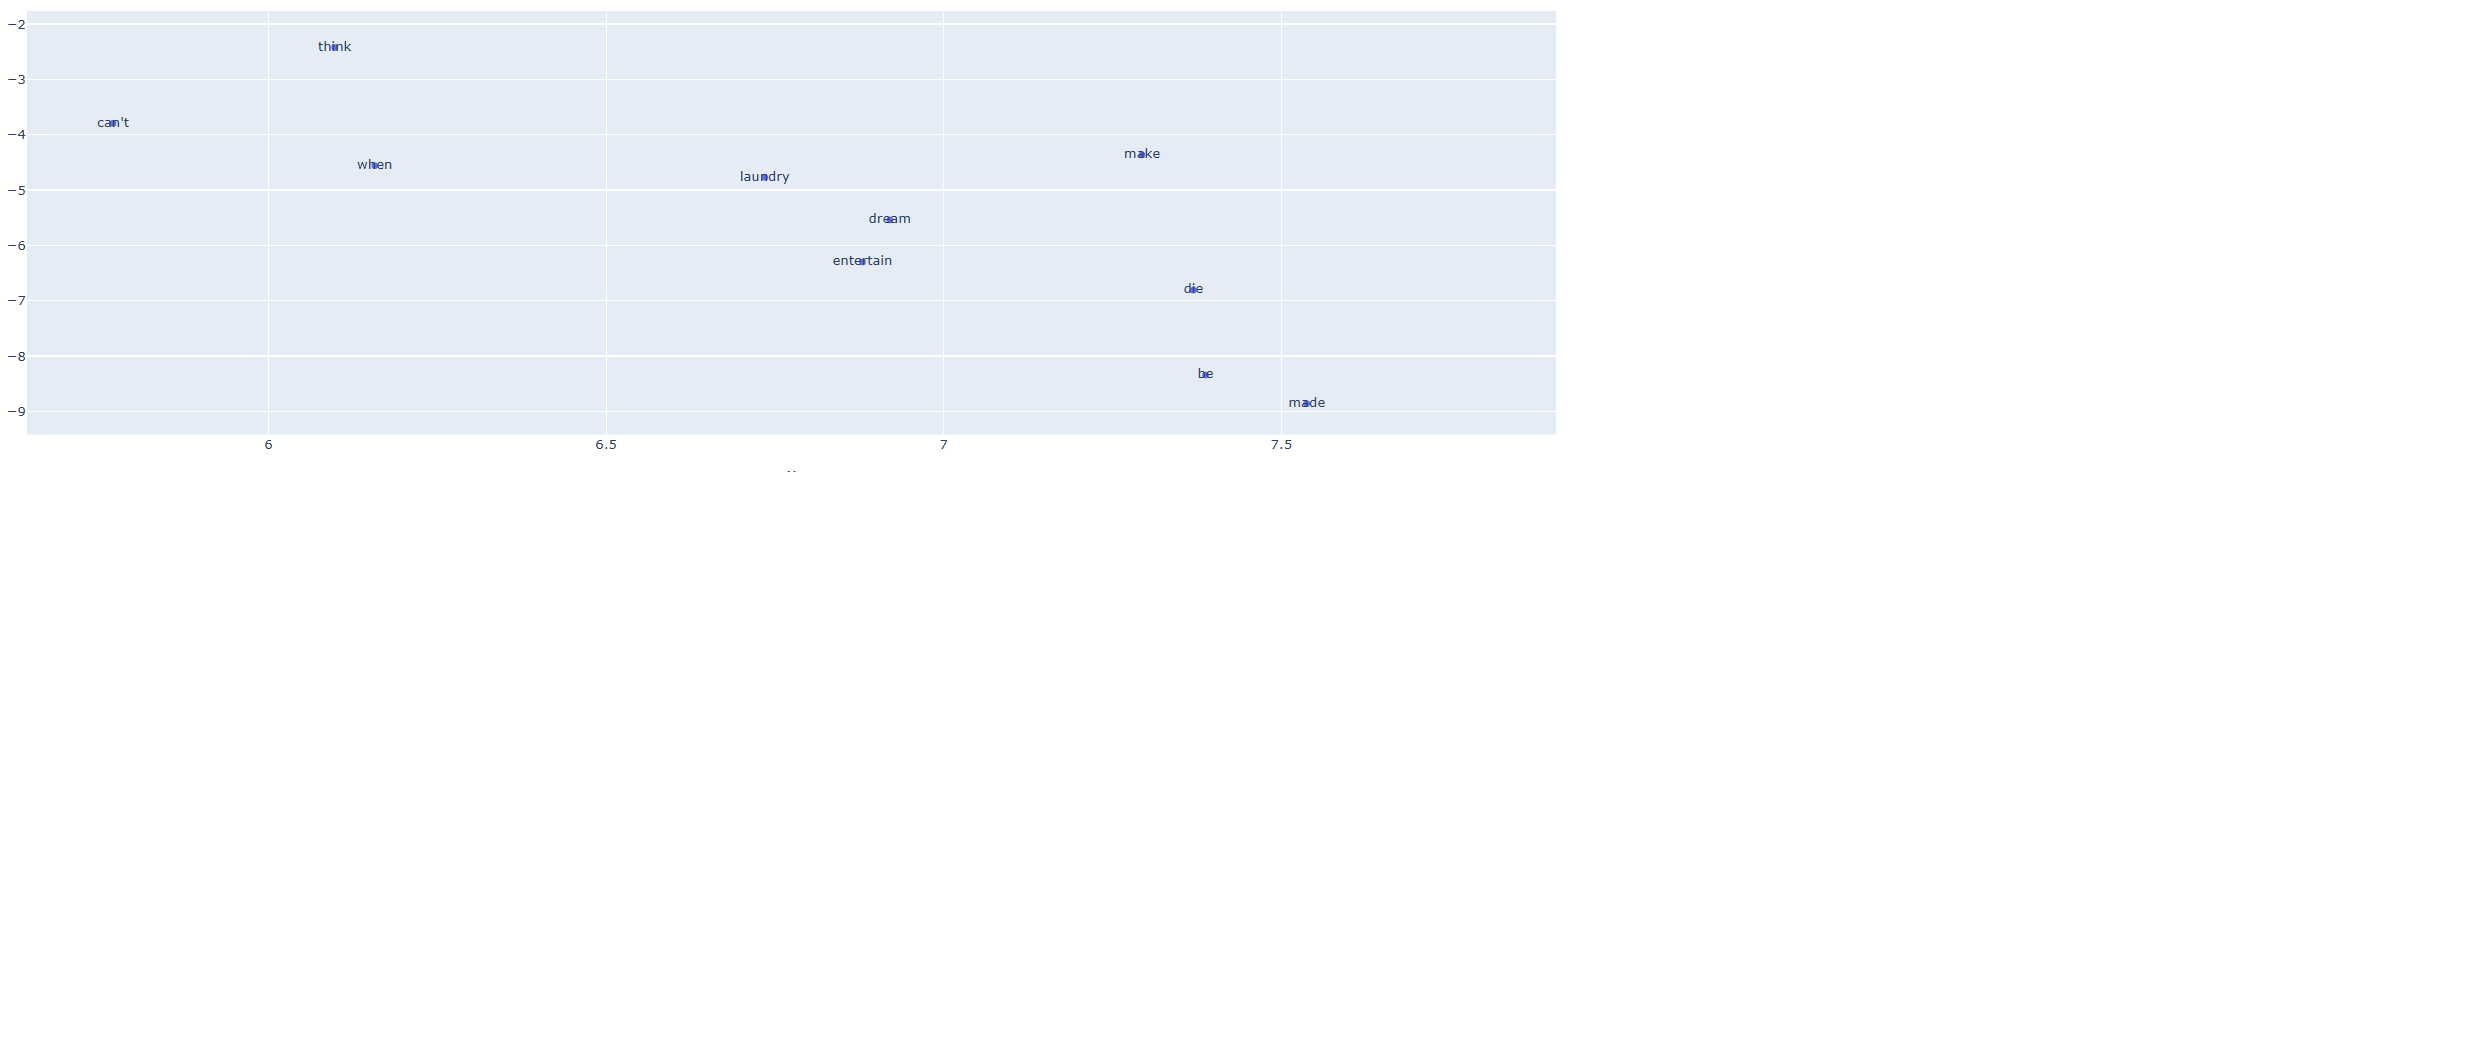